In [1]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/sebastian/Documents/KTH/Year 1/ID2223-SML/mlfs-book
HopsworksSettings initialized!


# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [2]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import hopsworks
from mlfs.airquality import util
import json

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
import json, datetime, hopsworks

project = hopsworks.login(project="air_quality_prediction")
fs = project.get_feature_store()
secrets = hopsworks.get_secrets_api()

AQICN_API_KEY = secrets.get_secret("AQICN_API_KEY").value

sensor_secret_names = [
    "SENSOR_LOCATION_bankgatan_JSON",
    "SENSOR_LOCATION_linakersvagen_JSON",
    "SENSOR_LOCATION_trollebergsvagen_JSON",
]

sensors = {}
for name in sensor_secret_names:
    raw = secrets.get_secret(name).value
    data = json.loads(raw)

    
    for k in ["country", "city", "street", "aqicn_url", "latitude", "longitude"]:
        assert k in data, f"{name}: missing key '{k}'"
    sensors[name.removeprefix("SENSOR_LOCATION_").removesuffix("_JSON")] = data


for sensor_name, info in sensors.items():
    print(json.dumps({sensor_name: info}, indent=2))


for sensor_name, info in sensors.items():
    print(
        f"{sensor_name}: "
        f"{info.get('city')} – {info.get('street')} | "
        f"{info.get('latitude')} , {info.get('longitude')} | "
        f"{info.get('country')} | {info.get('aqicn_url')}"
    )


2025-11-18 13:32:07,936 INFO: Initializing external client
2025-11-18 13:32:07,937 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-18 13:32:09,821 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1271977
{
  "bankgatan": {
    "country": "sweden",
    "city": "lund",
    "street": "bankgatan",
    "aqicn_url": "https://api.waqi.info/feed/A530461",
    "latitude": 55.74,
    "longitude": 13.18
  }
}
{
  "linakersvagen": {
    "country": "sweden",
    "city": "lund",
    "street": "lin\u00e5kersv\u00e4gen",
    "aqicn_url": "https://api.waqi.info/feed/A415507",
    "latitude": 55.74,
    "longitude": 13.18
  }
}
{
  "trollebergsvagen": {
    "country": "sweden",
    "city": "lund",
    "street": "trollebergsv\u00e4gen",
    "aqicn_url": "https://api.waqi.info/feed/@10017",
    "latitude": 55.74,
    "longitude": 13.18
  }
}
bankgatan: lund – bankgatan | 55.74 , 13.18 | sweden | https://api.waqi.info/feed/A530461
linakersvagen: lund – linåkersvägen | 55.74 , 13.18 | sweden | https://api.waqi.info/feed/A415507
trollebergsvagen: lund – trollebergsvägen | 5

In [4]:
# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

In [5]:
selected_features_no_lag = air_quality_fg.select(['pm25','street','date']).join(weather_fg.select_features(), on=['city'])
selected_features_1lag = air_quality_fg.select(['pm25','pm25_lag_1day','street','date']).join(weather_fg.select_features(), on=['city'])
selected_features_2lags = air_quality_fg.select(['pm25','pm25_lag_1day','pm25_lag_2day','street','date']).join(weather_fg.select_features(), on=['city'])
selected_features_3lags = air_quality_fg.select(['pm25','pm25_lag_1day','pm25_lag_2day','pm25_lag_3day','street','date']).join(weather_fg.select_features(), on=['city'])

2025-11-18 13:32:12,613 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.
2025-11-18 13:32:12,613 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.
2025-11-18 13:32:12,614 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.
2025-11-18 13:32:12,615 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.


### Feature Views

`Feature Views` are selections of features from different **Feature Groups** that make up the input and output API (or schema) for a model. A **Feature Views** can create **Training Data** and also be used in Inference to retrieve inference data.

The Feature Views allows a schema in form of a query with filters, defining a model target feature/label and additional transformation functions (declarative feature encoding).

In order to create Feature View we can use `FeatureStore.get_or_create_feature_view()` method.

You can specify the following parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - declarative feature encoding (not used here)

- `query` - selected features/labels for the model 

In [6]:
label_encoder = fs.get_transformation_function(name='label_encoder')

feature_view_no_lag = fs.get_or_create_feature_view(
    name='air_quality_fv_no_lag',
    description="weather features with air quality as the target",
    version=1,
    labels=['pm25'],
    query=selected_features_no_lag,
)


feature_view_1lag = fs.get_or_create_feature_view(
    name='air_quality_fv_1lag',
    description="weather features with 1 day lag and air quality as the target",
    version=1,
    labels=['pm25'],
    query=selected_features_1lag,
)

feature_view_2lags = fs.get_or_create_feature_view(
    name='air_quality_fv_2lags',
    description="weather features with 2 days lags and air quality as the target",
    version=1,
    labels=['pm25'],
    query=selected_features_2lags,
)


feature_view_3lags = fs.get_or_create_feature_view(
    name='air_quality_fv_3lags',
    description="weather features with 3 days lags and air quality as the target",
    version=1,
    labels=['pm25'],
    query=selected_features_3lags,
)

## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date

In [7]:
start_date_test_data = "2025-05-01"
# Convert string to datetime object
test_start = datetime.datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [8]:
print(test_start)

2025-05-01 00:00:00


In [9]:
feature_views = {
    'no_lag': feature_view_no_lag,
    '1_lag': feature_view_1lag,
    '2_lags': feature_view_2lags,
    '3_lags': feature_view_3lags
}

train_test_splits = {}
for name, fv in feature_views.items():
    X_train, X_test, y_train, y_test = fv.train_test_split(test_start=test_start)
    train_test_splits[name] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'feature_view_name': fv
    }

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.36s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.19s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.31s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.01s) 


In [10]:
X_train

,pm25_lag_1day,pm25_lag_2day,pm25_lag_3day,street,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,NaN,NaN,NaN,linåkersvägen,2023-09-19 00:00:00+00:00,16.607750,2.2,43.849125,223.720810
1,1.52,NaN,NaN,linåkersvägen,2023-09-20 00:00:00+00:00,17.855663,2.4,34.110828,216.606293
2,1.67,1.52,NaN,linåkersvägen,2023-09-21 00:00:00+00:00,19.324417,0.0,19.862083,151.625809
3,2.08,1.67,1.52,linåkersvägen,2023-09-22 00:00:00+00:00,17.018167,0.9,26.260265,199.119781
4,2.20,2.08,1.67,linåkersvägen,2023-09-23 00:00:00+00:00,14.043167,6.7,20.799152,232.790771
...,...,...,...,...,...,...,...,...,...
737,27.00,16.00,16.00,trollebergsvägen,2025-04-29 00:00:00+00:00,11.841084,0.0,20.268990,295.097473
738,3.25,1.80,1.80,bankgatan,2025-04-29 00:00:00+00:00,11.841084,0.0,20.268990,295.097473
739,1.30,2.00,0.85,linåkersvägen,2025-04-30 00:00:00+00:00,12.834836,0.0,20.019690,296.915588
740,24.00,27.00,16.00,trollebergsvägen,2025-04-30 00:00:00+00:00,12.834836,0.0,20.019690,296.915588


In [11]:
processed_data = {}
street_encoder = LabelEncoder()

for name, splits in train_test_splits.items():
    X_train = splits['X_train'].drop(columns=['date'])
    X_test = splits['X_test'].drop(columns=['date'])
    
    street_test = X_test['street'].copy()
    
    X_train['street_encode'] = street_encoder.fit_transform(X_train['street'])
    X_test['street_encode'] = street_encoder.transform(X_test['street'])
    
    X_train = X_train.drop(columns=['street'])
    X_test = X_test.drop(columns=['street'])
    
    processed_data[name] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': splits['y_train'],
        'y_test': splits['y_test'],
        'street_test': street_test
    }

In [12]:
from sklearn.preprocessing import LabelEncoder

In [13]:
y_train

,pm25
0,1.52
1,1.67
2,2.08
3,2.20
4,0.88
...,...
737,24.00
738,1.88
739,1.65
740,21.00


The `Feature View` is now saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view(name='...', version=1)`.

---

## <span style="color:#ff5f27;">🧬 Modeling</span>

We will train a regression model to predict pm25 using our 4 features (wind_speed, wind_dir, temp, precipitation)

In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 150, 200, 250, 300],
    "max_depth": [3, 5, 10],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.8, 1.0]
}

results = {}

for name, data in processed_data.items():
    print(f"Training model: {name}")
    
    xgb_regressor = XGBRegressor(random_state=42)
    grid = GridSearchCV(param_grid=param_grid, estimator=xgb_regressor, scoring="neg_mean_squared_error", cv=5) # we use the negative mse because GridSearch looks for the parameters that maximise the loss
    grid.fit(data['X_train'], data['y_train'])
    
    print(f"Best params: {grid.best_params_}")
    print(f"Best CV MSE: {-grid.best_score_:.4f}")
    
    results[name] = {
        'model': grid.best_estimator_,
        'best_params': grid.best_params_,
        'cv_mse': -grid.best_score_
    }

print("Performance Comparison (Cross-Validation)")
print(f"{'Model':<15} {'CV MSE':<12}")
for name, res in results.items():
    print(f"{name:<15} {res['cv_mse']:<12.4f}")

Training model: no_lag
Best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.8}
Best CV MSE: 152.6318
Training model: 1_lag
Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best CV MSE: 91.8195
Training model: 2_lags
Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best CV MSE: 88.4046
Training model: 3_lags
Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best CV MSE: 86.2914
Performance Comparison (Cross-Validation)
Model           CV MSE      
no_lag          152.6318    
1_lag           91.8195     
2_lags          88.4046     
3_lags          86.2914     


In [15]:
best_model_name = min(results.items(), key=lambda x: x[1]['cv_mse'])[0]
best_model_info = results[best_model_name]
best_data = processed_data[best_model_name]

y_pred = best_model_info['model'].predict(best_data['X_test'])
y_test = best_data['y_test']

mse = mean_squared_error(y_test.iloc[:,0], y_pred)
r2 = r2_score(y_test.iloc[:,0], y_pred)

print(f"Best performing model (based on CV): {best_model_name}")
print(f"CV MSE: {best_model_info['cv_mse']:.4f}")
print(f"Best params: {best_model_info['best_params']}")
print(f"\nTest Set Performance:")
print(f"Test MSE: {mse:.4f}")
print(f"Test R²: {r2:.4f}")

xgb_regressor = best_model_info['model']

Best performing model (based on CV): 3_lags
CV MSE: 86.2914
Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

Test Set Performance:
Test MSE: 48.5377
Test R²: 0.6708


In [16]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

In [17]:
best_splits = train_test_splits[best_model_name]
X_test = best_splits['X_test']

df = y_test.copy()
df['predicted_pm25'] = y_pred
df['street'] = best_data['street_test']
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(5)

,pm25,predicted_pm25,street,date
742,2.92,1.949392,linåkersvägen,2025-05-01 00:00:00+00:00
743,46.00,35.828491,trollebergsvägen,2025-05-01 00:00:00+00:00
744,5.29,3.275560,bankgatan,2025-05-01 00:00:00+00:00
745,33.00,37.549374,trollebergsvägen,2025-05-02 00:00:00+00:00
746,2.80,4.256895,bankgatan,2025-05-02 00:00:00+00:00


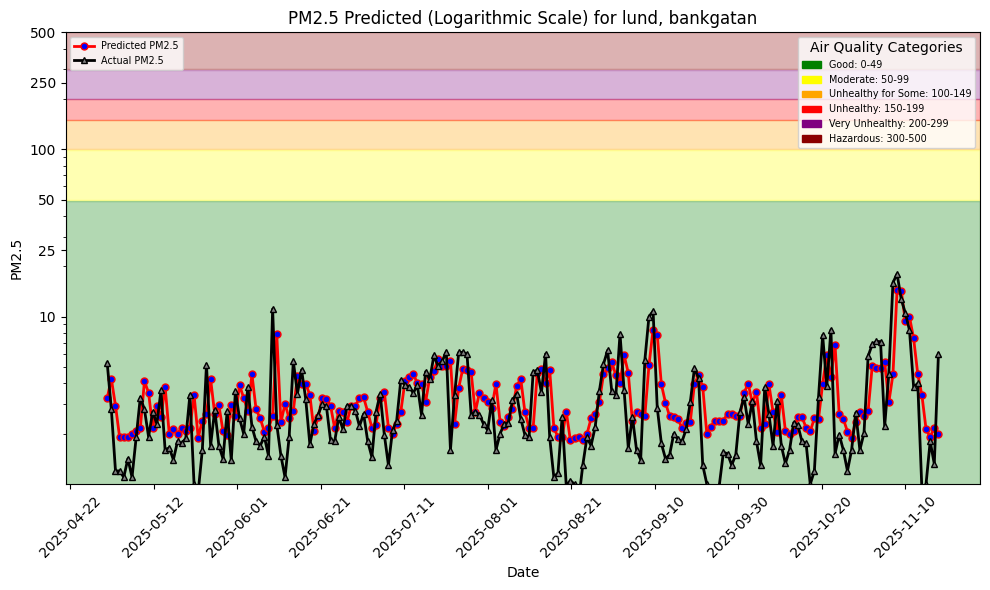

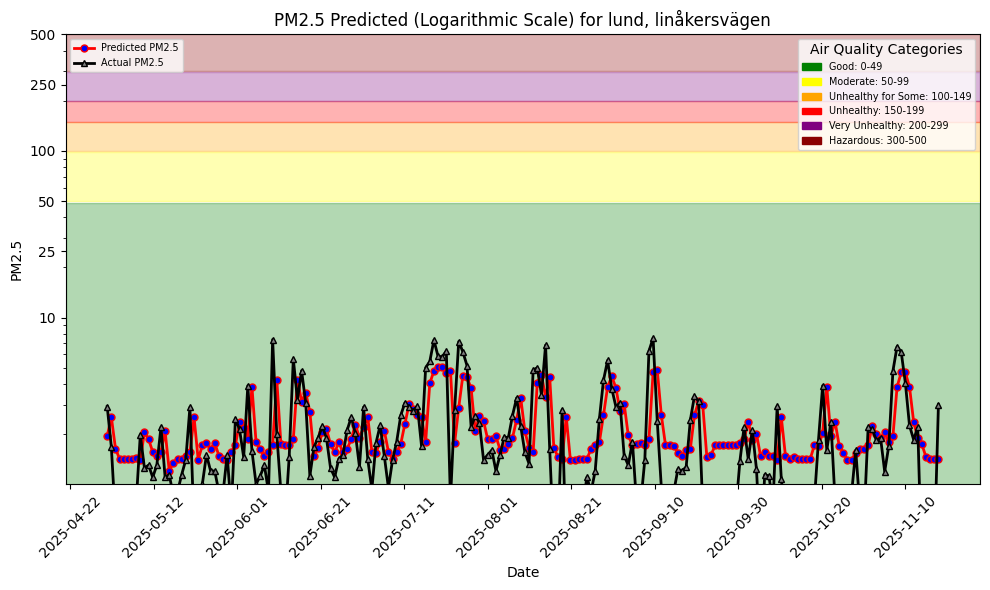

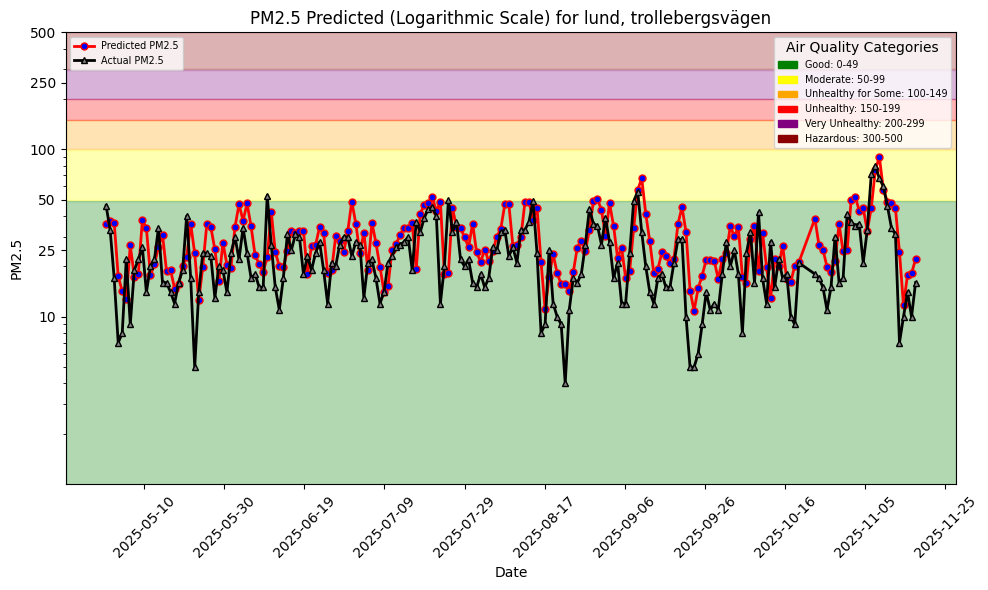

In [18]:
# Filter for each street
for sensor_name, info in sensors.items():
    city = info.get('city')
    street = info.get('street')
    
    # Filter df for this specific street
    street_df = df[df['street'] == street].copy()
    
    if len(street_df) > 0:
        file_path = images_dir + "/pm25_hindcast_" + street + '.png'
        plt = util.plot_air_quality_forecast(city, street, street_df, file_path, hindcast=True) 
        plt.show()
    else:
        print(f"No predictions found for {street}")

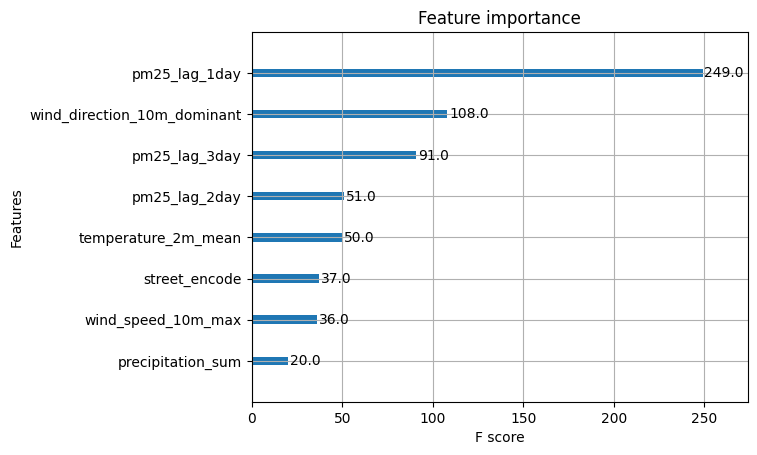

In [19]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

In [20]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [21]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [22]:
mr = project.get_model_registry()

feature_view = feature_views[best_model_name]

print(f"Using feature view {feature_view} for model in registry.")

aq_model = mr.python.create_model(
    name="air_quality_xgboost_model", 
    metrics= res_dict,
    feature_view=feature_view,
    description=f"Air Quality (PM2.5) predictor with {best_model_name} features",
)

aq_model.save(model_dir)

Using feature view <hsfs.feature_view.FeatureView object at 0x1380f8400> for model in registry.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/sebastian/Documents/KTH/Year 1/ID2223-SML/mlfs-book/notebooks/airquality/air_quality_model/mo…

Uploading /Users/sebastian/Documents/KTH/Year 1/ID2223-SML/mlfs-book/notebooks/airquality/air_quality_model/im…

Uploading /Users/sebastian/Documents/KTH/Year 1/ID2223-SML/mlfs-book/notebooks/airquality/air_quality_model/im…

Uploading /Users/sebastian/Documents/KTH/Year 1/ID2223-SML/mlfs-book/notebooks/airquality/air_quality_model/im…

Uploading /Users/sebastian/Documents/KTH/Year 1/ID2223-SML/mlfs-book/notebooks/airquality/air_quality_model/im…

Uploading /Users/sebastian/Documents/KTH/Year 1/ID2223-SML/mlfs-book/notebooks/airquality/model_schema.json: 0…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1271977/models/air_quality_xgboost_model/3


Model(name: 'air_quality_xgboost_model', version: 3)

---
## <span style="color:#ff5f27;">⏭️ **Next:** Part 04: Batch Inference</span>

In the following notebook you will use your model for Batch Inference.
